## 1 需要导入的包

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Normal
import random
import math
import numpy as np
import gymnasium as gym
from collections import deque
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 2 定义算法

### 2.1 定义网络

In [2]:
# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)

class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()

        # Q1 architecture
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, num_actions)

        # Q2 architecture
        self.linear4 = nn.Linear(num_inputs, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, hidden_dim)
        self.linear6 = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)

    def forward(self, state):
        xu = state
        
        x1 = F.relu(self.linear1(xu))
        x1 = F.relu(self.linear2(x1))
        x1 = self.linear3(x1)

        x2 = F.relu(self.linear4(xu))
        x2 = F.relu(self.linear5(x2))
        x2 = self.linear6(x2)

        return x1, x2


class PolicyNet(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(PolicyNet, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)


    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        probs = F.softmax(x, -1)
        z = probs == 0.0
        z = z.float() * 1e-8
        return x, probs + z

### 2.2 经验回放类

In [3]:
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)


### 2.3 定义SAC_D

In [4]:
class SAC_D:
    def __init__(self, cfg) -> None:
        self.n_states = cfg.n_states
        self.n_actions = cfg.n_actions
        self.action_space = cfg.action_space
        self.sample_count = 0
        self.update_count = 0
        self.gamma = cfg.gamma
        self.tau = cfg.tau
        self.alpha = cfg.alpha
        self.n_epochs = cfg.n_epochs
        self.target_update = cfg.target_update
        self.automatic_entropy_tuning = cfg.automatic_entropy_tuning
        self.batch_size = cfg.batch_size
        self.memory = ReplayBuffer(cfg.buffer_size)
        self.device = torch.device(cfg.device)
        self.critic = QNetwork(cfg.n_states, cfg.n_actions, cfg.hidden_dim).to(device=self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=cfg.lr)
        self.critic_target = QNetwork(cfg.n_states, cfg.n_actions, cfg.hidden_dim).to(self.device)

        self.target_entropy = 0.98 * (-np.log(1 / self.n_actions))
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha = self.log_alpha.exp()
        self.alpha_optim = Adam([self.log_alpha], lr=cfg.lr)

        self.epsilon = cfg.epsilon_start
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        self.policy = PolicyNet(cfg.n_states, cfg.n_actions, cfg.hidden_dim).to(self.device)
        self.policy_optim = Adam(self.policy.parameters(), lr=cfg.lr)

    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                       math.exp(-1. * self.sample_count / self.epsilon_decay)
        if random.random() < self.epsilon:
            action = random.randrange(self.n_actions)
        else:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)
            q_values, _ = self.policy(state)
            action = q_values.max(1)[1].item()  # choose action corresponding to the maximum q value
        return action

    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)
        q_values, _ = self.policy(state)
        action = q_values.max(1)[1].item()  # choose action corresponding to the maximum q value
        return action  # .detach().cpu().numpy()[0]

    def update(self):
        ''' 更新网络
        '''
        if len(self.memory) < self.batch_size:  # when transitions in memory donot meet a batch, not update
            return
        for i in range(self.n_epochs):
            self.update_count += 1
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
                batch_size=self.batch_size)

            # state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
            state_batch = torch.tensor(state_batch, device=self.device,  dtype=torch.float)
            action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
            reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float).unsqueeze(1)
            next_state_batch = torch.tensor(next_state_batch, device=self.device, dtype=torch.float)
            done_batch = torch.tensor(done_batch, device=self.device, dtype=torch.float).unsqueeze(1)

            with torch.no_grad():
                next_state_action, next_probs = self.policy(next_state_batch)
                next_log_probs = torch.log(next_probs)

                qf1_next_target, qf2_next_target = self.critic_target(next_state_batch)
                min_qf_next_target = (next_probs * (
                            torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_log_probs)).sum(
                    -1).unsqueeze(-1)
                next_q_value = reward_batch + (1 - done_batch) * self.gamma * (min_qf_next_target)

            qf1, qf2 = self.critic(
                state_batch)  # Two Q-functions to mitigate positive bias in the policy improvement step
            qf1 = qf1.gather(1, action_batch)
            qf2 = qf2.gather(1, action_batch)

            qf1_loss = F.mse_loss(qf1,
                                  next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
            qf2_loss = F.mse_loss(qf2,
                                  next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
            qf_loss = qf1_loss + qf2_loss

            self.critic_optim.zero_grad()
            qf_loss.backward()
            for param in self.critic.parameters():
                param.grad.data.clamp_(-1, 1)
            self.critic_optim.step()

            pi, probs = self.policy(state_batch)
            log_probs = torch.log(probs)
            with torch.no_grad():
                qf1_pi, qf2_pi = self.critic(state_batch)
                min_qf_pi = torch.min(qf1_pi, qf2_pi)
            policy_loss = (probs * ((
                                                self.alpha * log_probs) - min_qf_pi)).mean()  # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]

            self.policy_optim.zero_grad()
            policy_loss.backward()
            for param in self.policy.parameters():
                param.grad.data.clamp_(-1, 1)
            self.policy_optim.step()

            log_probs = (probs * log_probs).sum(-1)
            alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()

            # hard update
            if self.update_count % self.target_update == 0:
                for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                    target_param.data.copy_(param.data)

    def save_model(self, fpath):
        ''' 保存模型
        '''
        from pathlib import Path
        # create path
        Path(fpath).mkdir(parents=True, exist_ok=True)

        torch.save({'policy_state_dict': self.policy.state_dict(),
                    'critic_state_dict': self.critic.state_dict(),
                    'critic_target_state_dict': self.critic_target.state_dict(),
                    'critic_optimizer_state_dict': self.critic_optim.state_dict(),
                    'policy_optimizer_state_dict': self.policy_optim.state_dict()}, f"{fpath}/checkpoint.pt")

    def load_model(self, fpath):
        ''' 加载模型
        '''
        checkpoint = torch.load(f"{fpath}/checkpoint.pt", map_location=self.device)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.critic_target.load_state_dict(checkpoint['critic_target_state_dict'])
        self.critic_optim.load_state_dict(checkpoint['critic_optimizer_state_dict'])
        self.policy_optim.load_state_dict(checkpoint['policy_optimizer_state_dict'])

## 3 模型训练和测试

In [5]:
def train(cfg, env, agent):
    print("开始训练！")
    rewards = []
    steps = []
    for i in range(cfg.train_eps):
        ep_reward = 0  # reward per episode
        ep_step = 0
        state = env.reset()  # reset and obtain initial state
        state = state[0]
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # sample action
            next_state, reward, terminated, truncated, info = env.step(action)  # update env and return transitions under new_step_api of OpenAI Gym
            agent.memory.push((state, action, reward, next_state, terminated))  # save transitions
            agent.update()  # update agent
            state = next_state  # update next state for env
            ep_reward += reward  #
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i + 1) % 10 == 0:
            print(f"回合：{i + 1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    print("完成训练！")
    # res = {'ep_reward': ep_reward, 'ep_step': ep_step}
    return {'rewards': rewards}


def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    print(cfg.test_eps)
    for i in range(cfg.test_eps):
        ep_reward = 0  # reward per episode
        ep_step = 0
        state = env.reset()  # reset and obtain initial state
        state = state[0]
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.predict_action(state)  # sample action
            next_state, reward, terminated, truncated , info = env.step(action)  # update env and return transitions under new_step_api of OpenAI Gym
            state = next_state  # update next state for env
            ep_reward += reward  #
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i + 1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards': rewards}


In [6]:
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.reset(seed=seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    all_seed(env,seed=cfg.seed)
    print(env.observation_space.shape)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    setattr(cfg, 'action_space', env.action_space) 
    agent = SAC_D(cfg)
    return env,agent

## 4 配置参数

In [7]:
class Config:
    def __init__(self):
        # 通用参数
        self.env_name = "Acrobot-v1"  # name of environment
        self.algo_name = "SAC_D"  # name of algorithm
        self.mode = "train"  # train, test
        self.device = "cpu"  # device to use
        self.seed = 0  # random seed
        self.train_eps = 100  # number of episodes for training
        self.test_eps = 50
        self.max_steps = 200  # max steps for each episode
        self.collect_traj = False  # if collect trajectory or not
        # multiprocessing settings
        self.mp_backend = "single"  # multiprocessing backend: "ray", default "single"
        self.n_workers = 1  # number of workers
        self.n_learners = 1  # number of learners if using multi-processing, default 1
        self.share_buffer = True  # if all learners share the same buffer
        # online evaluation settings
        self.online_eval = False  # online evaluation or not
        self.online_eval_episode = 10  # online eval episodes
        self.model_save_fre = 500  # model save frequency per update step
        # load model settings
        self.load_checkpoint = False  # if load checkpoint
        self.load_path = ""  # path to load model
        self.load_model_step = 'best'  # load model at which step

        # 算法参数
        self.epsilon_start = 0.95  # epsilon start value
        self.epsilon_end = 0.01  # epsilon end value
        self.epsilon_decay = 500  # epsilon decay rate
        self.lr = 1e-3  # learning rate
        self.gamma = 0.99  # discount factor
        self.tau = 0.005  # soft update factor
        self.alpha = 0.1  # Temperature parameter α determines the relative importance of the entropy term against the reward # 0.1
        self.automatic_entropy_tuning = False  # automatically adjust α
        self.batch_size = 64  # batch size # 256
        self.hidden_dim = 256  # hidden dimension # 256
        self.n_epochs = 1  # number of epochs
        self.target_update = 1  # interval for updating the target network
        self.buffer_size = 1000000  # replay buffer size

def smooth(data, weight=0.9):
        '''用于平滑曲线，类似于Tensorboard中的smooth曲线
        '''
        last = data[0]
        smoothed = []
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

def plot_rewards(rewards, title="learning curve"):
        sns.set()
        plt.figure()  # 创建一个图形实例，方便同时多画几个图
        plt.title(f"{title}")
        plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
        plt.xlabel('epsiodes')
        plt.plot(rewards, label='rewards')
        plt.plot(smooth(rewards), label='smoothed')
        plt.legend()


def print_cfgs(cfg):
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['='] * 80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k, v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        print(tplt.format(k, v, str(type(v))))
    print(''.join(['='] * 80))


## 5 开始训练和测试

In [ ]:
### 5.1 训练

Hyperparameters:
        Name        	       Value        	        Type        
      env_name      	     Acrobot-v1     	   <class 'str'>    
     algo_name      	       SAC_D        	   <class 'str'>    
        mode        	       train        	   <class 'str'>    
       device       	        cpu         	   <class 'str'>    
        seed        	         0          	   <class 'int'>    
     train_eps      	        100         	   <class 'int'>    
      test_eps      	         50         	   <class 'int'>    
     max_steps      	        200         	   <class 'int'>    
    collect_traj    	         0          	   <class 'bool'>   
     mp_backend     	       single       	   <class 'str'>    
     n_workers      	         1          	   <class 'int'>    
     n_learners     	         1          	   <class 'int'>    
    share_buffer    	         1          	   <class 'bool'>   
    online_eval     	         0          	   <class 'bool'>   
online_eval_episode 	         10      

/var/folders/w0/pdcqgg7107b13rvwb56gsrlc0000gn/T/ipykernel_78267/3389205337.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1669104549212/work/torch/csrc/utils/tensor_new.cpp:253.)
  state_batch = torch.tensor(state_batch, device=self.device,  dtype=torch.float)


回合：10/100，奖励：-200.00
回合：20/100，奖励：-200.00
回合：30/100，奖励：-200.00
回合：40/100，奖励：-200.00
回合：50/100，奖励：-200.00
回合：60/100，奖励：-200.00
回合：70/100，奖励：-200.00
回合：80/100，奖励：-200.00
回合：90/100，奖励：-200.00
回合：100/100，奖励：-200.00
完成训练！


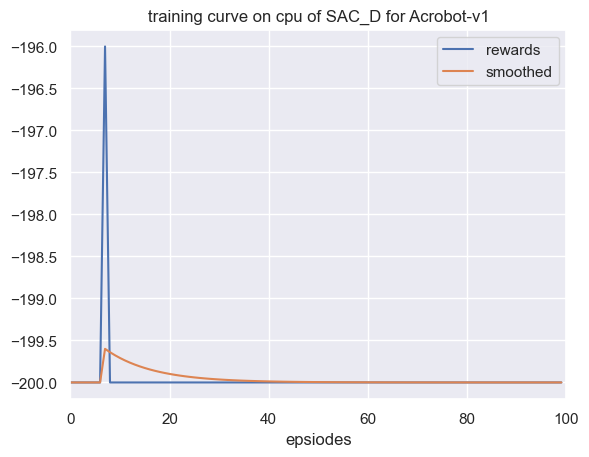

In [8]:
cfg = Config()
print_cfgs(cfg)
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)

plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")

开始测试！
50
回合：1/50，奖励：-200.00
回合：2/50，奖励：-200.00
回合：3/50，奖励：-200.00
回合：4/50，奖励：-200.00
回合：5/50，奖励：-200.00
回合：6/50，奖励：-200.00
回合：7/50，奖励：-200.00
回合：8/50，奖励：-200.00
回合：9/50，奖励：-200.00
回合：10/50，奖励：-200.00
回合：11/50，奖励：-200.00
回合：12/50，奖励：-200.00
回合：13/50，奖励：-200.00
回合：14/50，奖励：-200.00
回合：15/50，奖励：-200.00
回合：16/50，奖励：-200.00
回合：17/50，奖励：-200.00
回合：18/50，奖励：-200.00
回合：19/50，奖励：-200.00
回合：20/50，奖励：-200.00
回合：21/50，奖励：-200.00
回合：22/50，奖励：-200.00
回合：23/50，奖励：-200.00
回合：24/50，奖励：-200.00
回合：25/50，奖励：-200.00
回合：26/50，奖励：-200.00
回合：27/50，奖励：-200.00
回合：28/50，奖励：-200.00
回合：29/50，奖励：-200.00
回合：30/50，奖励：-200.00
回合：31/50，奖励：-200.00
回合：32/50，奖励：-200.00
回合：33/50，奖励：-200.00
回合：34/50，奖励：-200.00
回合：35/50，奖励：-200.00
回合：36/50，奖励：-200.00
回合：37/50，奖励：-200.00
回合：38/50，奖励：-200.00
回合：39/50，奖励：-200.00
回合：40/50，奖励：-200.00
回合：41/50，奖励：-200.00
回合：42/50，奖励：-200.00
回合：43/50，奖励：-200.00
回合：44/50，奖励：-200.00
回合：45/50，奖励：-200.00
回合：46/50，奖励：-200.00
回合：47/50，奖励：-200.00
回合：48/50，奖励：-200.00
回合：49/50，奖励：-200.00
回合：50/50，奖励：-200.00


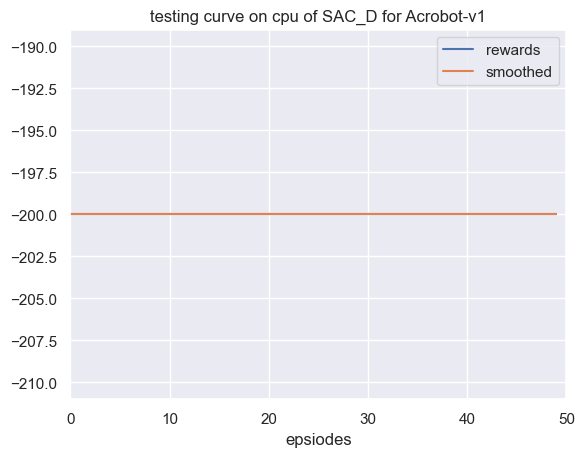

In [9]:
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  